<a href="https://colab.research.google.com/github/kap2fox/Intro-to-Robotics/blob/main/Motor_modeling_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Физика двигателя EV3
Друзья, мы с вами уже получили из основных фундаментальных законов физики уравнение для описания двигателя постоянного тока: $$\dot\omega+\frac{k_m k_e}{JR}\omega=\frac{k_m}{JR}U. \tag{1}$$ Это дифференциальное уравнение при известных начальных условиях имеет однозначное решение. Давайте попробуем решить его при помощи инструментов языка Python. Но для начала стоит сделать замену констант, чтобы упростить вычисления и сократить выражение. Введем электромеханическую константу: $$T_m=\frac{JR}{k_e k_m}.\tag{2}$$ Далее введем все необходимые параметры в рабочее пространство.

In [ ]:
import sympy                                  # импорт модуля символьных вычислений sympy                        
U, T_m, t = sympy.symbols("U, T_m","t")       # обозначение символов переменных напряжения, постоянной времени и самого времени
k_e = sympy.symbols("k_e",positive=True)      # конструктивная постоянная, должна быть положительной для однозначного решения уравнения
omega = sympy.Function("omega")               # обозначение функции угловой скорости

Мы импортировали необходимую нам библиотеку SymPy для выполнения символьных вычислений и описали все переменные, которые используются в уравнении 1 после подстановки замены констант 2. Теперь мы можем описать дифференциальное уравнение, указав зависимость скорости от времени: $$\dot\omega(t)=\frac{d}{dt}\omega=\frac{U}{T_m k_e}-\frac{\omega(t)}{T_m}. \tag{3}$$

In [ ]:
ode = sympy.Eq( omega(t).diff(t), U/(k_e*T_m) - omega(t)/T_m)   # задание дифференциального уравнения двигателя
ode

Eq(Derivative(omega(t), t), U/(T_m*k_e) - omega(t)/T_m)

Также мы точно знаем, что в начальный момент времени двигатель не вращается, и угол поворота равен нулю. Начальным условием для двигателя в мемент времени $t=0[sec]$ будет угловая скорость $\omega=0[rad/sec]$.

In [ ]:
ode_sol = sympy.dsolve(ode, omega(t), ics={omega(0):0})         # решение дифференциального уравнения с нулевыми начальными условиями
ode_sol

Eq(omega(t), (U - U*exp(-t/T_m))/k_e)

Мы получили аналитическое решение дифференциального уравнения при заданных начальных условиях. Также можно разбить полученную дробь на две части, для наглядности постоянной части уравнения и её экспоненциальной части.

In [ ]:
ode_sol = sympy.expand(ode_sol)                                 # упрощение результата решения
ode_sol

Eq(omega(t), U/k_e - U*exp(-t/T_m)/k_e)

Теперь у нас есть полноценное уравнение угловой скорости вращения двигателя постоянного тока, и мы можем изобразить его график. Я подставлю приблизительные показания постоянных двигателя Lego EV3, $T_m=0.08[sec]$,  $\ k_e=0.5[V*sec/rad]$,  $\ U=8[V]$.

In [ ]:
ode_num = ode_sol.subs({k_e : 0.5, T_m : 0.08, U : 8})          # подстановка числовых значений в уравнение
ode_num

Eq(omega(t), 16.0 - 16.0*exp(-12.5*t))

Теперь без проблем можно изобразить кривую разгона двигателя.

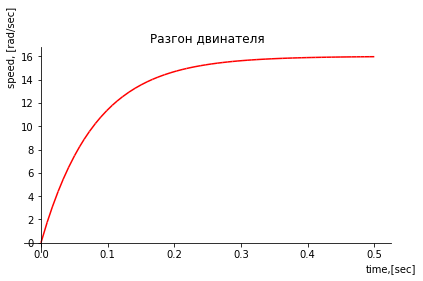

In [ ]:
from sympy.plotting import plot                                 # импорт функции изображения графиков
plot(ode_num.rhs,(t, 0, 0.5), line_color='red', 
     title='Разгон двинателя',xlabel = 'time,[sec]',
     ylabel = 'speed, [rad/sec]')                               # изображение графика с различными настройками

Двигатель Lego EV3 имеет датчик угла поворота двигателя, оптический энкодер. Поэтому для работы с моделью двигателя нам понадобится угол поворота, а не угловая скорость. И мы можем получить ее, взяв интеграл от угловой скорости по времени в промежутке от 0 до текущего времени t.

In [ ]:
theta_eq = sympy.integrate(ode_sol.rhs,(t,0,t))                 # интегрирование правой части уравнения угловой скорости
theta_eq

-T_m*U/k_e + T_m*U*exp(-t/T_m)/k_e + U*t/k_e

Также уравнение угла поворота двигателя можно получить, решив дифференциальное уравнение относительно угла поворота $\omega=\dot\theta$, то есть $$\ddot\theta=\frac{U}{T_m k_e}-\frac{\dot\theta}{T_m}.  \tag{4}$$ При этом начальные условия также сохраняются, в момент времени $t = 0[sec]$ угол поворота двигателя равен $\theta = 0[rad]$ и угловая скорость $\dot\theta = 0[rad]$. Ниже проведем проверку результата интегрирования на предыдущем шаге, обратите внимание, как задается начальное условие $\dot\theta(0)=0$:

In [ ]:
theta = sympy.Function("theta")                                                 # задание функции угла поворота
ode_theta = sympy.Eq( theta(t).diff(t,2), - theta(t).diff(t)/T_m + U/(k_e*T_m)) # задание дифференциального уравнения
ode_sol_theta = sympy.dsolve(ode_theta, theta(t), 
                             ics={theta(0):0, theta(t).diff(t).subs(t,0): 0})   # решение дифференциального уравнения
ode_sol_theta

Eq(theta(t), -T_m*U/k_e + T_m*U*exp(-t/T_m)/k_e + U*t/k_e)

Последним шагом изобразим график угла поворота двигателя, чтобы в дальнейшем сравнить его с реальными показаниями.

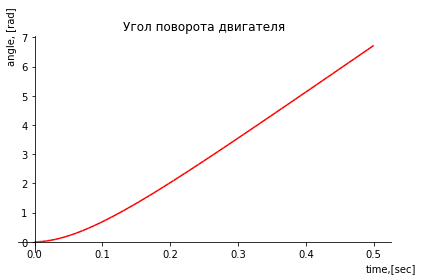

In [ ]:
theta_num = ode_sol_theta.subs({k_e : 0.5, T_m : 0.08, U : 8})                  # подстановка численных значений
plot(theta_num.rhs,(t, 0, 0.5), line_color='red', 
     title='Угол поворота двигателя',
     xlabel = 'time,[sec]', ylabel = 'angle, [rad]')                            # изображение графика